In [9]:
!pip install svgwrite cairosvg rdp

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.3 MB/s eta 0:00:00
  Created wheel for rdp: filename=rdp-0.8-py3-none-any.whl size=4584 sha256=6fd2858d5be318064c6b9a974efd958ede2cf7b210d2672fc908602b7c5f0815
  Stored in directory: /root/.cache/pip/wheels/5d/12/ec/0fc50553af000b9c3d2c74b9f77a01ae4bfe856e9917ac239c
Successfully built rdp


In [1]:
#Plotting a Numpy array
import numpy as np
from scipy.spatial import ConvexHull

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []

        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)

        path_XYs.append(XYs)

    return path_XYs


def plot(paths_XYs, colours):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))

    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]

        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)

    ax.set_aspect('equal')
    plt.show()


# Isolated shapes

In [2]:
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
from skimage.measure import EllipseModel


def regularize_rounded_rectangle(points):
    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)
    width = max_coords[0] - min_coords[0]
    height = max_coords[1] - min_coords[1]

    # Approximate radius of rounded corners
    corner_radius = min(width, height) * 0.1

    # Define the corner points
    corners = [
        [min_coords[0] + corner_radius, min_coords[1] + corner_radius],
        [max_coords[0] - corner_radius, min_coords[1] + corner_radius],
        [max_coords[0] - corner_radius, max_coords[1] - corner_radius],
        [min_coords[0] + corner_radius, max_coords[1] - corner_radius]
    ]

    # Define the rectangle with rounded corners
    x = [p[0] for p in corners] + [corners[0][0]]
    y = [p[1] for p in corners] + [corners[0][1]]

    return np.column_stack((x, y))

def regularize_polygon(points):
    center = np.mean(points, axis=0)
    radius = np.mean(np.linalg.norm(points - center, axis=1))
    num_sides = len(points)

    angles = np.linspace(0, 2 * np.pi, num_sides, endpoint=False)
    x = center[0] + radius * np.cos(angles)
    y = center[1] + radius * np.sin(angles)

    return np.column_stack((x, y))



In [3]:
def regularize_line(points):
    if len(points) < 2:
        return np.array([])  # Not enough points to form a line

    # Fit a line to the points
    p1, p2 = points[0], points[-1]
    x = np.array([p1[0], p2[0]])
    y = np.array([p1[1], p2[1]])

    return np.column_stack((x, y))


def regularize_ellipse(points):
    if len(points) < 5:
        return np.array([])  # Not enough points to fit an ellipse

    # Fit an ellipse to the points
    ellipse = EllipseModel()
    ellipse.estimate(points)
    xc, yc, a, b, theta = ellipse.params

    num_points = len(points)
    theta_values = np.linspace(0, 2 * np.pi, num_points)
    x = xc + a * np.cos(theta_values) * np.cos(theta) - b * np.sin(theta_values) * np.sin(theta)
    y = yc + a * np.cos(theta_values) * np.sin(theta) + b * np.sin(theta_values) * np.cos(theta)

    return np.column_stack((x, y))




# **Main code**

In [4]:

from scipy.interpolate import splprep, splev
def regularize_circle(points, max_width, max_height, scale_factor=0.9):
    center = np.mean(points, axis=0)
    radius = np.median(np.linalg.norm(points - center, axis=1))

    # Calculate the scale based on the minimum dimension
    min_dimension = min(max_width, max_height)
    scale = (min_dimension * scale_factor) / (2 * radius)

    num_points = len(points)
    theta = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    x = center[0] + radius * scale * np.cos(theta)
    y = center[1] + radius * scale * np.sin(theta)

    return np.column_stack((x, y))



def regularize_rectangle(points, max_width, max_height, scale_factor=0.9):
    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)

    width = max_coords[0] - min_coords[0]
    height = max_coords[1] - min_coords[1]

    scale_x = (max_width * scale_factor) / width
    scale_y = (max_height * scale_factor) / height

    # Center of the original rectangle
    center = np.mean(points, axis=0)

    x = [min_coords[0], max_coords[0], max_coords[0], min_coords[0], min_coords[0]]
    y = [min_coords[1], min_coords[1], max_coords[1], max_coords[1], min_coords[1]]

    # Scale and center the rectangle
    x = center[0] + (np.array(x) - center[0]) * scale_x
    y = center[1] + (np.array(y) - center[1]) * scale_y

    return np.column_stack((x, y))


def regularize_star(points):
    center = np.mean(points, axis=0)
    max_radius = np.max(np.linalg.norm(points - center, axis=1))
    min_radius = max_radius * 0.4  # Adjusted inner radius for more pronounced star

    num_points = 10  # Number of points in the star (5 outer, 5 inner)
    angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    radii = np.zeros(num_points)
    radii[::2] = max_radius  # Outer points
    radii[1::2] = min_radius  # Inner points

    x = center[0] + radii * np.cos(angles)
    y = center[1] + radii * np.sin(angles)

    # Ensure the star shape is closed
    x = np.append(x, x[0])
    y = np.append(y, y[0])

    return np.column_stack((x, y))


def calculate_perimeter(hull):
    perimeter = 0
    for i in range(len(hull.vertices)):
        p1 = hull.points[hull.vertices[i]]
        p2 = hull.points[hull.vertices[(i + 1) % len(hull.vertices)]]
        perimeter += np.linalg.norm(p1 - p2)
    return perimeter

def calculate_num_vertices(points):
    # Implement a method to estimate or count the number of vertices in the shape
    # This can involve techniques such as convex hull vertices count, etc.
    hull = ConvexHull(points)
    return len(hull.vertices)

def identify_shape(points):
    print(len(points))
    if len(points) < 3:
        return 'unknown'  # Not enough points to determine shape

    hull = ConvexHull(points)
    hull_area = hull.volume
    hull_perimeter = calculate_perimeter(hull)

    if hull_perimeter == 0:
        return 'unknown'

    compactness = 4 * np.pi * hull_area / (hull_perimeter ** 2)

    print(f"Compactness: {compactness}, Hull Area: {hull_area}, Hull Perimeter: {hull_perimeter}")

    if compactness > 0.88:
        print("Identified as circle")
        return 'circle'

    aspect_ratio = calculate_aspect_ratio(points)
    if 0.8 < aspect_ratio < 1.2:
        print("Identified as rectangle")
        return 'rectangle'

    num_vertices = calculate_num_vertices(points)

    # Adjust aspect ratio threshold for star
    if num_vertices > 5 and (aspect_ratio < 0.9 or aspect_ratio > 2) and compactness < 0.9:
        print("Identified as star")
        return 'star'

    return 'unknown'


def calculate_max_extents(points):
    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)
    width = max_coords[0] - min_coords[0]
    height = max_coords[1] - min_coords[1]
    return width, height

def calculate_aspect_ratio(points):
    hull = ConvexHull(points)
    hull_points = hull.points[hull.vertices]

    # Calculate distances between vertices
    dists = [np.linalg.norm(hull_points[i] - hull_points[(i + 1) % len(hull_points)]) for i in range(len(hull_points))]
    width, height = sorted(dists)[:2]

    return max(width, height) / min(width, height)


def regularize_shape(points):
    if len(points) == 0:
        return np.array([])  # Return empty array for empty input

    # Determine the maximum extents from the irregular shape
    max_width, max_height = calculate_max_extents(points)

    shape_type = identify_shape(points)

    if shape_type == 'circle':
        return regularize_circle(points, max_width, max_height)
    elif shape_type == 'rectangle':
        return regularize_rectangle(points, max_width, max_height)
    elif shape_type=='star':
        return regularize_star(points)
    else:
      return biezer_curve_fit(points)


def bezier_curve_fit(points, num_points=100):
    tck, u = splprep(points.T, s=0)
    u_new = np.linspace(u.min(), u.max(), num_points)
    x_new, y_new = splev(u_new, tck, der=0)
    return np.vstack((x_new, y_new)).T


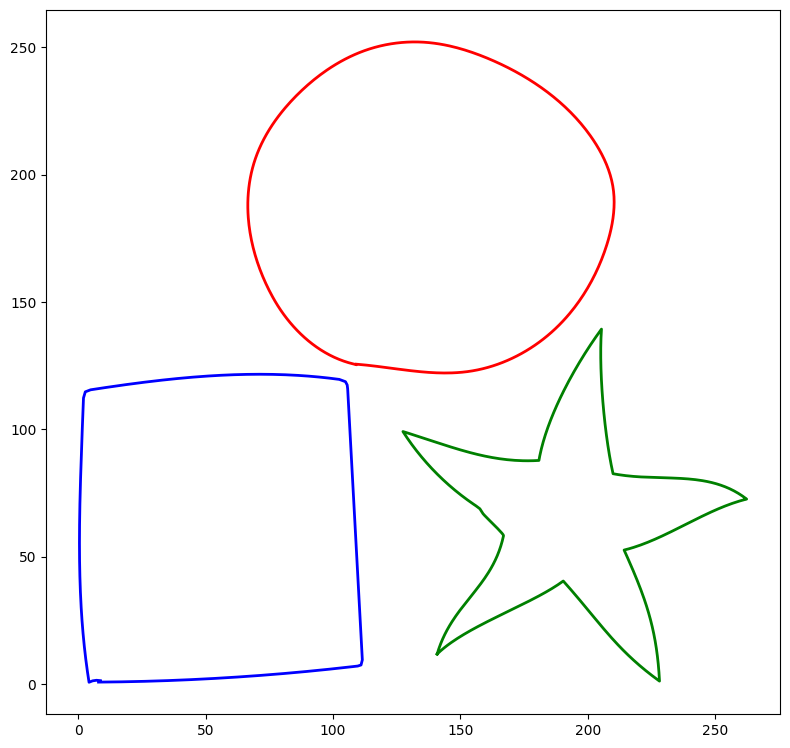

419
Compactness: 0.992289823063742, Hull Area: 14574.535798978466, Hull Perimeter: 429.6185540054191
Identified as circle
550
Compactness: 0.8633480837869744, Hull Area: 12747.868521835717, Hull Perimeter: 430.7554243917191
Identified as star
423
Compactness: 0.8290063799208852, Hull Area: 12521.755472778517, Hull Perimeter: 435.6709521916299
Identified as rectangle


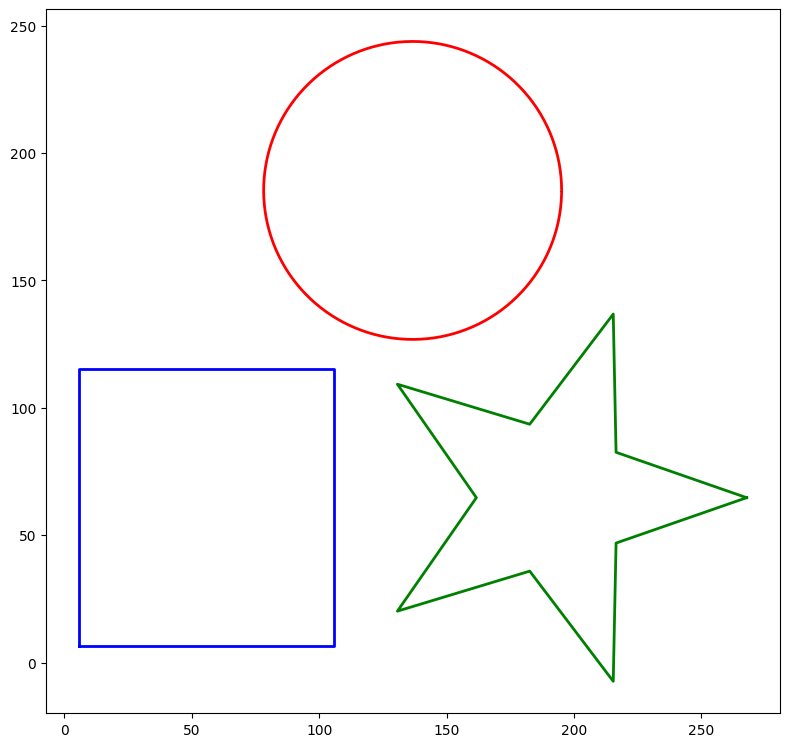

In [5]:
colours = ['r', 'g', 'b', 'y']
pathXY=read_csv('/content/isolated.csv')
regularized_path_XYs = []
plot(pathXY,colours)

for path in pathXY:
    regularized_path = []
    for shape in path:
        regularized_shape = regularize_shape(shape)
        regularized_path.append(regularized_shape)
    regularized_path_XYs.append(regularized_path)
plot(regularized_path_XYs, colours)

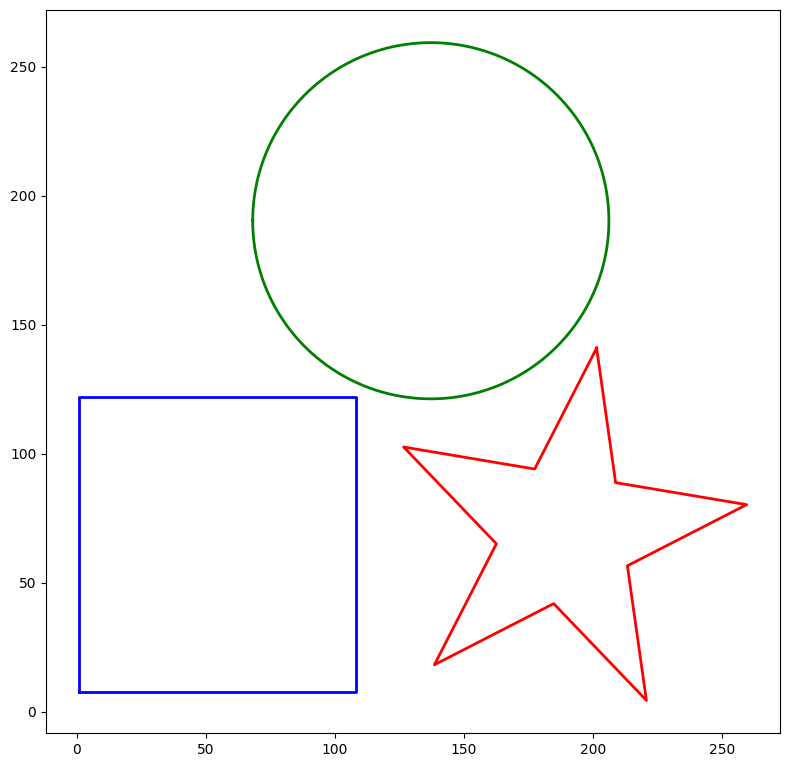

In [ ]:
pathXY=read_csv('/content/isolated_sol.csv')
plot(pathXY,colours)

# Fragments divison


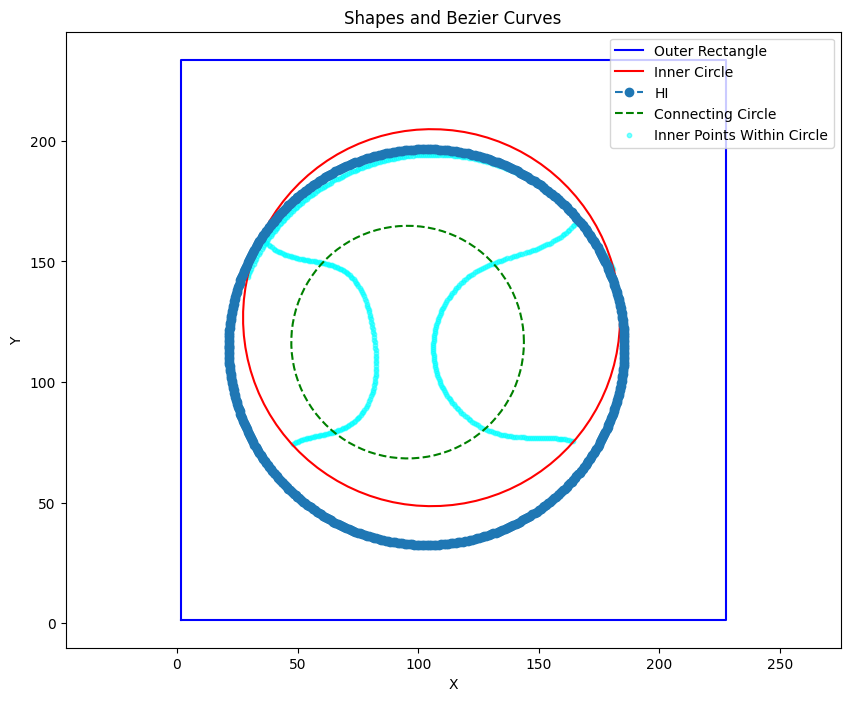

Number of outer points: 650
Number of inner points: 1125
Number of inner points within circle: 555
Average Center: [ 95.61763422 116.55016885]
Average Radius: 48.20560442523089


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.interpolate import splprep, splev

# Define functions for processing and plotting shapes
def group_fragments(fragments):
    coords = np.concatenate(fragments, axis=0)  # Combine all fragments into one array
    clustering = DBSCAN(eps=5, min_samples=2).fit(coords)
    labels = clustering.labels_

    grouped_fragments = {}
    for label, coord in zip(labels, coords):
        if label not in grouped_fragments:
            grouped_fragments[label] = []
        grouped_fragments[label].append(coord)
    return grouped_fragments

def merge_rectangle(fragments):
    x_coords, y_coords = zip(*fragments)
    min_x, max_x = min(x_coords), max(x_coords)
    min_y, max_y = min(y_coords), max(y_coords)
    return [
        (min_x, min_y),
        (max_x, min_y),
        (max_x, max_y),
        (min_x, max_y),
        (min_x, min_y)
    ]

def merge_circle(fragments):
    x_coords, y_coords = zip(*fragments)
    center_x, center_y = np.mean(x_coords), np.mean(y_coords)
    radius = np.mean([np.sqrt((x - center_x)**2 + (y - center_y)**2) for x, y in fragments])
    theta = np.linspace(0, 2 * np.pi, 100)
    return [(center_x + radius * np.cos(t), center_y + radius * np.sin(t)) for t in theta]

def fit_bezier_curve(fragments):
    fragments = np.array(fragments)
    tck, u = splprep(fragments.T, s=0)
    u_fine = np.linspace(0, 1, 100)
    x_fine, y_fine = splev(u_fine, tck)
    return list(zip(x_fine, y_fine))

def identify_shape(fragments):
    # Implement a simple heuristic or method to distinguish between rectangles and circles
    # This is a placeholder; you may need a more complex approach
    if len(fragments) > 20:  # Arbitrary threshold for simplicity
        return "circle"
    return "rectangle"

def separate_shapes(fragments):
    all_points = np.concatenate(fragments)

    min_x, min_y = np.min(all_points, axis=0)
    max_x, max_y = np.max(all_points, axis=0)

    margin = 5

    outer_points = []
    inner_points = []

    for point in all_points:
        if (point[0] <= min_x + margin or point[0] >= max_x - margin or
            point[1] <= min_y + margin or point[1] >= max_y - margin):
            outer_points.append(point)
        else:
            inner_points.append(point)

    return np.array(outer_points), np.array(inner_points)

def fit_rectangle(points):
    min_x, min_y = np.min(points, axis=0)
    max_x, max_y = np.max(points, axis=0)
    return [(min_x, min_y), (max_x, min_y), (max_x, max_y), (min_x, max_y), (min_x, min_y)]

def fit_circle(points):
    center = np.mean(points, axis=0)
    radius = np.mean(np.linalg.norm(points - center, axis=1))
    theta = np.linspace(0, 2 * np.pi, 100)
    return [(center[0] + radius * np.cos(t), center[1] + radius * np.sin(t)) for t in theta], center, radius

def fit_bezier_curve(points):
    try:
        unique_points = np.unique(points, axis=0)
        if len(unique_points) < 4:
            print("Not enough unique points to fit a Bezier curve.")
            return None

        tck, u = splprep(unique_points.T, s=0, k=min(3, len(unique_points) - 1))
        u_new = np.linspace(0, 1, 100)
        x_new, y_new = splev(u_new, tck)
        return list(zip(x_new, y_new))
    except Exception as e:
        print(f"Error fitting Bezier curve: {e}")
        return None

def filter_points_within_circle(points, center, radius):
    distances = np.sqrt((points[:, 0] - center[0])**2 + (points[:, 1] - center[1])**2)
    return points[distances < radius]  # Exclude boundary points

def plot_curves_within_circle(curves, center, radius):
    for curve in curves:
        x_curve, y_curve = zip(*curve)
        # Check if the curve points are within the circle
        distances = np.sqrt((np.array(x_curve) - center[0])**2 + (np.array(y_curve) - center[1])**2)
        if np.all(distances <= radius):
            plt.plot(x_curve, y_curve, '--', color='green', label='Inner Bezier Curve')

# Main execution

path_XYs = read_csv('/content/frag0.csv')
all_fragments = [fragment for shape_frag in path_XYs for fragment in shape_frag]
path_x = read_csv('/content/frag01_sol.csv')

sample_points =path_x[2][0]

outer_points, inner_points = separate_shapes(all_fragments)

# Fit outer rectangle
rectangle = fit_rectangle(outer_points)

# Fit circle
circle, center, radius = fit_circle(inner_points)

# Filter inner points that are truly within the circle (excluding boundary points)
inner_points_within_circle = filter_points_within_circle(inner_points, center, radius)

plt.figure(figsize=(10, 8))

# Plot outer rectangle
x_rect, y_rect = zip(*rectangle)
plt.plot(x_rect, y_rect, '-', color='blue', label='Outer Rectangle')

# Plot inner circle
x_circle, y_circle = zip(*circle)
plt.plot(x_circle, y_circle, '-', color='red', label='Inner Circle')

plt.plot(sample_points[:, 0], sample_points[:, 1], 'o--', label="HI")

# Apply clustering to inner points within the circle
db = DBSCAN(eps=5, min_samples=10).fit(inner_points_within_circle)
labels = db.labels_

# Collect Bezier curves for each cluster
bezier_curves = []
unique_labels = set(labels)
for label in unique_labels:
    if label == -1:
        continue  # Skip noise points

    cluster_points = inner_points_within_circle[labels == label]
    bezier_curve = fit_bezier_curve(cluster_points)
    if bezier_curve:
        bezier_curves.append(bezier_curve)

# Calculate average center and radius for the circle connecting the ellipses
ellipse_centers = [np.mean(curve, axis=0) for curve in bezier_curves]
average_center = np.mean(ellipse_centers, axis=0)
average_radius = np.mean([np.mean(np.linalg.norm(np.array(curve) - average_center, axis=1)) for curve in bezier_curves])
theta = np.linspace(0, 2 * np.pi, 100)
connecting_circle = [(average_center[0] + average_radius * np.cos(t), average_center[1] + average_radius * np.sin(t)) for t in theta]

# Plot the circle connecting the ellipses
x_connecting_circle, y_connecting_circle = zip(*connecting_circle)
plt.plot(x_connecting_circle, y_connecting_circle, '--', color='green', label='Connecting Circle')

# Plot the inner points within the circle
plt.scatter(inner_points_within_circle[:, 0], inner_points_within_circle[:, 1], s=10, color='cyan', alpha=0.5, label='Inner Points Within Circle')

plt.legend()
plt.title("Shapes and Bezier Curves")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.show()

# Print some diagnostic information
print(f"Number of outer points: {len(outer_points)}")
print(f"Number of inner points: {len(inner_points)}")
print(f"Number of inner points within circle: {len(inner_points_within_circle)}")
print(f"Average Center: {average_center}")
print(f"Average Radius: {average_radius}")


# Fragments


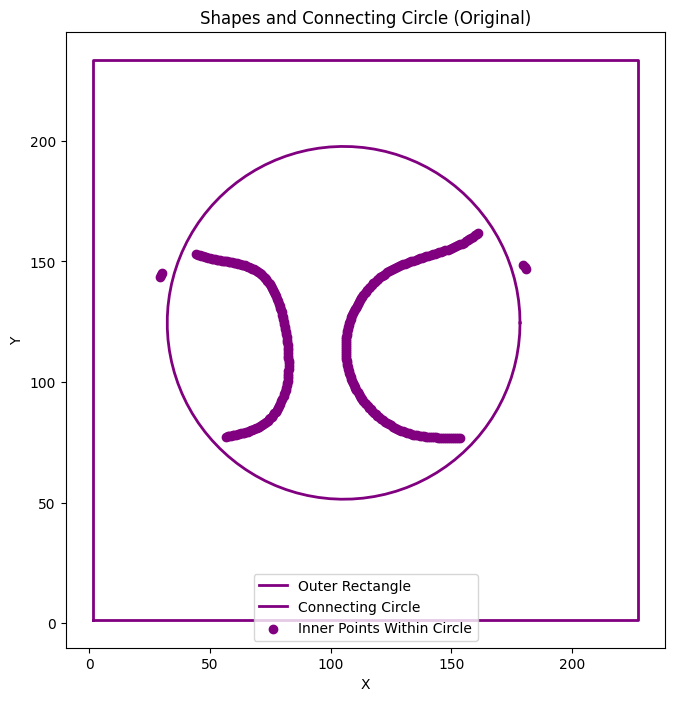

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.cluster import DBSCAN

def fit_circle_to_ellipse_points(points, center, radius):
    distances = np.sqrt((points[:, 0] - center[0])**2 + (points[:, 1] - center[1])**2)
    boundary_points = points[np.abs(distances - radius) < 10]  # Adjust threshold as needed

    if len(boundary_points) < 3:
        print("Not enough boundary points to fit a circle.")
        return None, None

    def circle_fit_error(params):
        c_x, c_y, r = params
        return np.sum((np.sqrt((boundary_points[:, 0] - c_x)**2 +
                               (boundary_points[:, 1] - c_y)**2) - r)**2)

    initial_guess = [center[0], center[1], radius]
    result = minimize(circle_fit_error, initial_guess, method='Nelder-Mead')
    new_center_x, new_center_y, new_radius = result.x

    theta = np.linspace(0, 2 * np.pi, 100)
    new_circle_points = np.column_stack([
        new_center_x + new_radius * np.cos(theta),
        new_center_y + new_radius * np.sin(theta)
    ])

    return new_circle_points, (new_center_x, new_center_y, new_radius)

def plot_shapes(rectangle, circle_points, inner_points, reflected_points=None, symmetry_type="Original"):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot outer rectangle
    if rectangle.size > 0:
        x_rect, y_rect = zip(*rectangle)
        ax.plot(x_rect, y_rect, '-', color='purple', linewidth=2, label='Outer Rectangle')

    # Plot connecting circle
    if circle_points.size > 0:
        ax.plot(circle_points[:, 0], circle_points[:, 1], color='purple', linewidth=2, label='Connecting Circle')

    # Plot inner points
    if inner_points.size > 0:
        ax.scatter(inner_points[:, 0], inner_points[:, 1], color='purple', label='Inner Points Within Circle')

    if reflected_points is not None:
        ax.scatter(reflected_points[:, 0], reflected_points[:, 1], color='orange', label=f'Reflected Points ({symmetry_type})')

    ax.set_aspect('equal')
    plt.title(f"Shapes and Connecting Circle ({symmetry_type})")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.show()

def reflect_points_across_vertical(points, x_line):
    return np.array([[2 * x_line - x, y] for x, y in points])

def reflect_points_across_horizontal(points, y_line):
    return np.array([[x, 2 * y_line - y] for x, y in points])

def reflect_points_across_line(points, line_point, line_direction):
    line_point = np.array(line_point)
    line_direction = np.array(line_direction) / np.linalg.norm(line_direction)

    reflected_points = []
    for point in points:
        point = np.array(point)
        projection_length = np.dot(point - line_point, line_direction)
        projection = line_point + projection_length * line_direction
        reflection = 2 * projection - point
        reflected_points.append(reflection)
    return np.array(reflected_points)

# Example usage
path_XYs = read_csv('/content/frag1.csv')
all_fragments = [fragment for shape_frag in path_XYs for fragment in shape_frag]

# Assuming separate_shapes, fit_rectangle, fit_circle, and filter_points_within_circle are defined elsewhere in your code
outer_points, inner_points = separate_shapes(all_fragments)

# Fit outer rectangle
rectangle = fit_rectangle(outer_points)

# Fit circle
circle, center, radius = fit_circle(inner_points)

# Filter inner points that are truly within the circle (excluding boundary points)
inner_points_within_circle = filter_points_within_circle(inner_points, center, radius)

# Apply clustering to inner points within the circle
db = DBSCAN(eps=5, min_samples=10).fit(inner_points_within_circle)
labels = db.labels_

# Fit and plot the connecting circle
new_circle_points, new_circle_params = fit_circle_to_ellipse_points(inner_points_within_circle, center, radius)

if new_circle_params:
    new_center_x, new_center_y, new_radius = new_circle_params
    distances_to_new_circle = np.sqrt((inner_points_within_circle[:, 0] - new_center_x)**2 +
                                      (inner_points_within_circle[:, 1] - new_center_y)**2)
    filtered_inner_points = inner_points_within_circle[np.abs(distances_to_new_circle - new_radius) >= 5]

# Create the required numpy arrays
rectangle_array = np.array(rectangle)
circle_array = np.array(new_circle_points) if new_circle_points is not None else np.array([])
filtered_inner_points_array = np.array(filtered_inner_points)

# Plot original points
plot_shapes(rectangle_array, circle_array, filtered_inner_points_array)


**Symmetry**

# Fragments 2

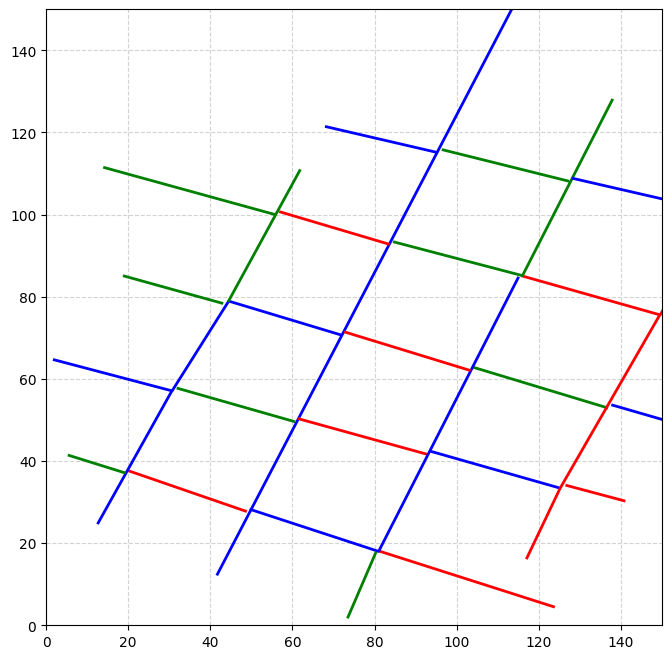

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from rdp import rdp



def apply_rdp(path_XYs, epsilon=1.0):
    simplified_paths = []
    for path in path_XYs:
        simplified_path = [rdp(segment, epsilon=epsilon) for segment in path]
        simplified_paths.append(simplified_path)
    return simplified_paths

def plot_paths(path_XYs, colours):
    fig, ax = plt.subplots(figsize=(8, 8))
    color_idx = 0
    for path in path_XYs:
        for segment in path:
            if len(segment) > 0:
                segment = np.array(segment)
                ax.plot(segment[:, 0], segment[:, 1], c=colours[color_idx % len(colours)], linewidth=2)
        color_idx += 1
    ax.set_aspect('equal')
    plt.xlim(0, 150)
    plt.ylim(0, 150)
    plt.grid(True, which='both', color='lightgray', linestyle='--')
    plt.show()

# Load and process data
csv_path = "/content/frag2.csv"
path_XYs = read_csv(csv_path)
simplified_paths = apply_rdp(path_XYs, epsilon=1.0)

# Define colors
colours = ['r', 'g', 'b']

# Plot the result
plot_paths(simplified_paths, colours)

**Symmetry**

In [11]:
def reflect_points_across_vertical(points, x_line):
    return np.array([[2 * x_line - x, y] for x, y in points])

def reflect_points_across_horizontal(points, y_line):
    return np.array([[x, 2 * y_line - y] for x, y in points])

def reflect_points_across_line(points, line_point, line_direction):
    line_point = np.array(line_point)
    line_direction = np.array(line_direction) / np.linalg.norm(line_direction)
    reflected_points = []
    for point in points:
        point = np.array(point)
        projection_length = np.dot(point - line_point, line_direction)
        projection = line_point + projection_length * line_direction
        reflection = 2 * projection - point
        reflected_points.append(reflection)
    return np.array(reflected_points)

def find_symmetry_and_reflect(path_XYs, symmetry_type):
    reflected_paths = []
    for path in path_XYs:
        reflected_path = []
        for segment in path:
            if symmetry_type == "vertical":
                x_line = (segment[:, 0].min() + segment[:, 0].max()) / 2
                reflected_segment = reflect_points_across_vertical(segment, x_line)
            elif symmetry_type == "horizontal":
                y_line = (segment[:, 1].min() + segment[:, 1].max()) / 2
                reflected_segment = reflect_points_across_horizontal(segment, y_line)
            elif symmetry_type == "diagonal":
                line_point = [(segment[:, 0].min() + segment[:, 0].max()) / 2,
                              (segment[:, 1].min() + segment[:, 1].max()) / 2]
                line_direction = [1, 1]  # 45-degree line
                reflected_segment = reflect_points_across_line(segment, line_point, line_direction)
            reflected_path.append(reflected_segment)
        reflected_paths.append(reflected_path)
    return reflected_paths

def plot_paths_with_symmetry(original_paths, reflected_paths, colours, symmetry_type):
    fig, ax = plt.subplots(figsize=(8, 8))
    color_idx = 0
    for original_path, reflected_path in zip(original_paths, reflected_paths):
        for segment, reflected_segment in zip(original_path, reflected_path):
            if len(segment) > 0:
                segment = np.array(segment)
                ax.plot(segment[:, 0], segment[:, 1], c=colours[color_idx % len(colours)], linewidth=2)
                ax.plot(reflected_segment[:, 0], reflected_segment[:, 1], c=colours[(color_idx + 1) % len(colours)], linestyle='--', linewidth=2)
        color_idx += 1
    ax.set_aspect('equal')
    plt.xlim(0, 150)
    plt.ylim(0, 150)
    plt.grid(True, which='both', color='lightgray', linestyle='--')
    plt.title(f"Original and {symmetry_type.capitalize()} Reflected Paths")
    plt.show()

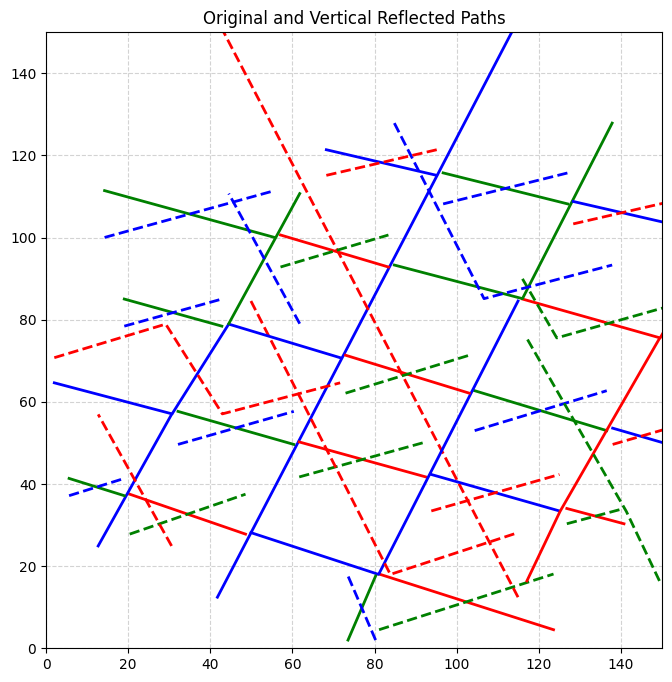

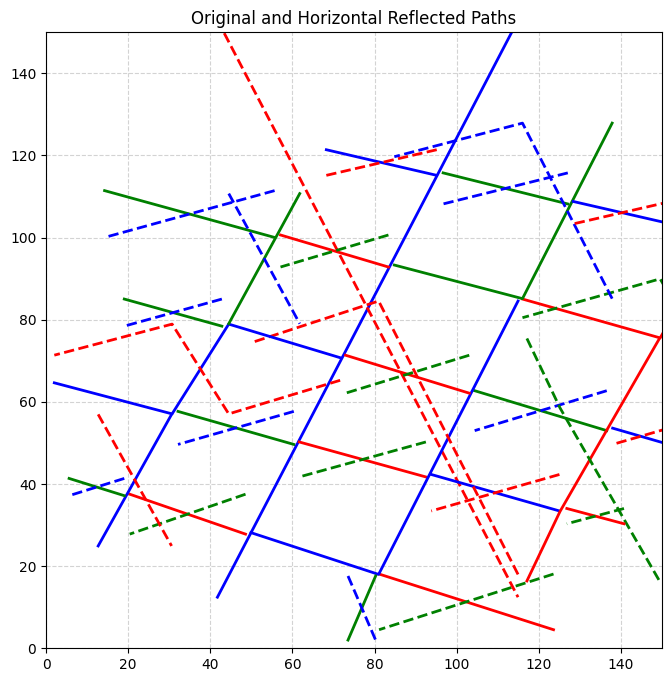

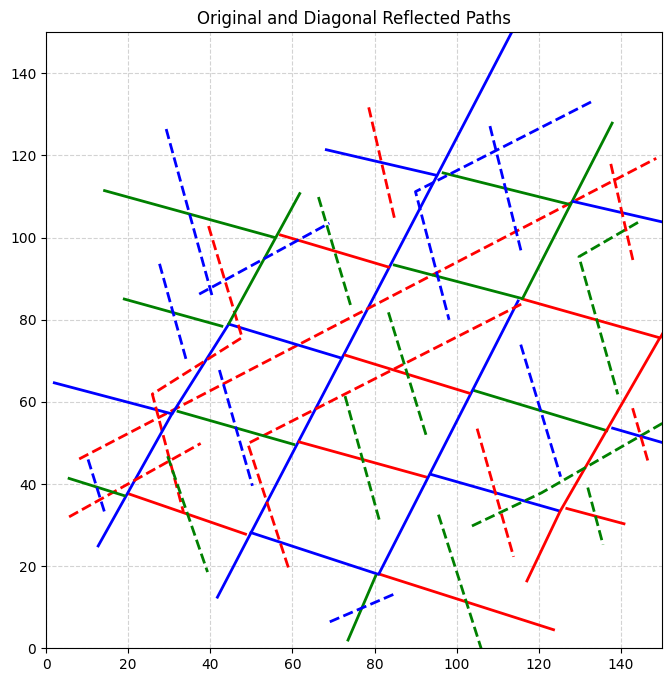

In [12]:
# Find and plot symmetry for vertical reflection
reflected_paths_vertical = find_symmetry_and_reflect(simplified_paths, "vertical")
plot_paths_with_symmetry(simplified_paths, reflected_paths_vertical, colours, "vertical")

# Find and plot symmetry for horizontal reflection
reflected_paths_horizontal = find_symmetry_and_reflect(simplified_paths, "horizontal")
plot_paths_with_symmetry(simplified_paths, reflected_paths_horizontal, colours, "horizontal")

# Find and plot symmetry for diagonal reflection
reflected_paths_diagonal = find_symmetry_and_reflect(simplified_paths, "diagonal")
plot_paths_with_symmetry(simplified_paths, reflected_paths_diagonal, colours, "diagonal")

# Occulsions


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy.interpolate import splprep, splev
from shapely.geometry import Polygon, MultiPolygon, GeometryCollection
from shapely.ops import unary_union
from shapely.validation import make_valid
from rdp import rdp



def rdp_simplify(path_XYs, epsilon=1.0):
    simplified_paths = []
    for path in path_XYs:
        simplified_path = []
        for shape in path:
            if len(shape) > 2:
                simplified_shape = rdp(shape, epsilon=epsilon)
                simplified_path.append(simplified_shape)
            else:
                simplified_path.append(shape)
        simplified_paths.append(simplified_path)
    return simplified_paths

def fill_occlusions(paths_XYs):
    filled_paths = []
    for path in paths_XYs:
        filled_path = []
        for shape in path:
            if len(shape) > 2:  # Only process shapes with more than 2 points
                hull = ConvexHull(shape)
                filled_shape = shape[hull.vertices]
            else:
                filled_shape = shape
            filled_path.append(filled_shape)
        filled_paths.append(filled_path)
    return filled_paths

def fit_bezier_curve(points, num_points=100):
    if len(points) < 2:
        return points
    tck, u = splprep([points[:, 0], points[:, 1]], s=0)
    u_fine = np.linspace(0, 1, num_points)
    x_fine, y_fine = splev(u_fine, tck)
    return np.vstack((x_fine, y_fine)).T

def plot_curves(paths_XYs, colours):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            if len(XY) > 2:
                bezier_curve = fit_bezier_curve(XY)
                ax.plot(bezier_curve[:, 0], bezier_curve[:, 1], c=c, linewidth=2)
                ax.fill(bezier_curve[:, 0], bezier_curve[:, 1], c=c, alpha=0.3)
            else:
                ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
                ax.fill(XY[:, 0], XY[:, 1], c=c, alpha=0.3)
    ax.set_aspect('equal')
    plt.show()

def analyze_connectivity(paths_XYs):
    polygons = []
    for path in paths_XYs:
        for shape in path:
            if len(shape) > 2:
                polygon = Polygon(shape)
                if polygon.is_valid:
                    polygons.append(polygon)
                else:
                    repaired_polygon = make_valid(polygon)
                    polygons.append(repaired_polygon)

    if not polygons:
        return "Disconnected"

    try:
        multi_polygon = MultiPolygon(polygons)
        unified_polygon = unary_union(multi_polygon)

        if isinstance(unified_polygon, Polygon):
            return "Connected"
        elif isinstance(unified_polygon, MultiPolygon):
            if len(unified_polygon.geoms) == 1:
                return "Connected"
            else:
                return "Disconnected"
        elif isinstance(unified_polygon, GeometryCollection):
            valid_polygons = [geom for geom in unified_polygon.geoms if isinstance(geom, Polygon) and geom.is_valid]
            if valid_polygons:
                multi_polygon = MultiPolygon(valid_polygons)
                if len(multi_polygon.geoms) == 1:
                    return "Connected"
                else:
                    return "Disconnected"
            else:
                return "Disconnected"
    except Exception as e:
        print(f"Error in connectivity analysis: {e}")
        return "Disconnected"

def process_csv_and_fill_occlusions(input_csv, colours):
    # Process input CSV
    input_paths_XYs = read_csv(input_csv)

    # Apply RDP simplification
    simplified_paths_XYs = rdp_simplify(input_paths_XYs, epsilon=1.0)
    print("Plotting input curves...")
    plot_curves(simplified_paths_XYs, colours)
    input_result = analyze_connectivity(simplified_paths_XYs)

    # Fill occlusions
    filled_paths_XYs = fill_occlusions(simplified_paths_XYs)
    print("Plotting filled curves...")
    plot_curves(filled_paths_XYs, colours)
    output_result = analyze_connectivity(filled_paths_XYs)

    print(f"Input image: {input_result}")
    print(f"Output image: {output_result}")

    if input_result == "Disconnected" and output_result == "Connected":
        print("Occlusion has been filled")
    else:
        print("No change in connectivity")



**Partial occulsion**

In [15]:
import numpy as np
import svgwrite
import cairosvg

def polylines2svg(paths_XYs, svg_path, colours):
    # Determine the canvas size
    W, H = 0, 0
    for path_XYs in paths_XYs:
        for XY in path_XYs:
            W = max(W, np.max(XY[:, 0]))
            H = max(H, np.max(XY[:, 1]))

    padding = 0.1
    W, H = int(W + padding * W), int(H + padding * H)

    # Create a new SVG drawing
    dwg = svgwrite.Drawing(svg_path, profile='tiny', shape_rendering='crispEdges')
    group = dwg.g()

    for i, path in enumerate(paths_XYs):
        path_data = []
        c = colours[i % len(colours)]
        for XY in path:
            path_data.append(("M", (XY[0, 0], XY[0, 1])))
            for j in range(1, len(XY)):
                path_data.append(("L", (XY[j, 0], XY[j, 1])))
            if not np.allclose(XY[0], XY[-1]):
                path_data.append(("Z", None))
        group.add(dwg.path(d=path_data, fill=c, stroke='none', stroke_width=2))

    dwg.add(group)
    dwg.save()

    # Convert SVG to PNG
    png_path = svg_path.replace('.svg', '.png')
    fact = max(1, 1024 // min(H, W))
    cairosvg.svg2png(
        url=svg_path,
        write_to=png_path,
        parent_width=W,
        parent_height=H,
        output_width=fact * W,
        output_height=fact * H,
        background_color='white'
    )

    return



In [ ]:
# Example usage
input_csv = '/content/occlusion1.csv'
colours = ['red', 'green']

process_csv_and_fill_occlusions(input_csv, colours)

paths_XYs=read_csv(input_csv)
simplified_paths_XYs = rdp_simplify(paths_XYs, epsilon=1.0)
polylines2svg(simplified_paths_XYs, 'simplified_paths.svg', colours)

**Disconnected occulsion**

Plotting input curves...


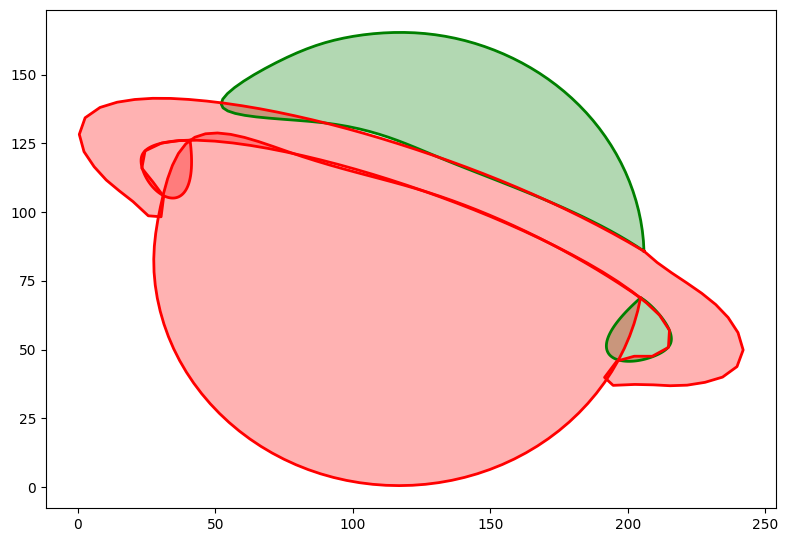

Error in connectivity analysis: 'MultiPolygon' object is not subscriptable
Plotting filled curves...


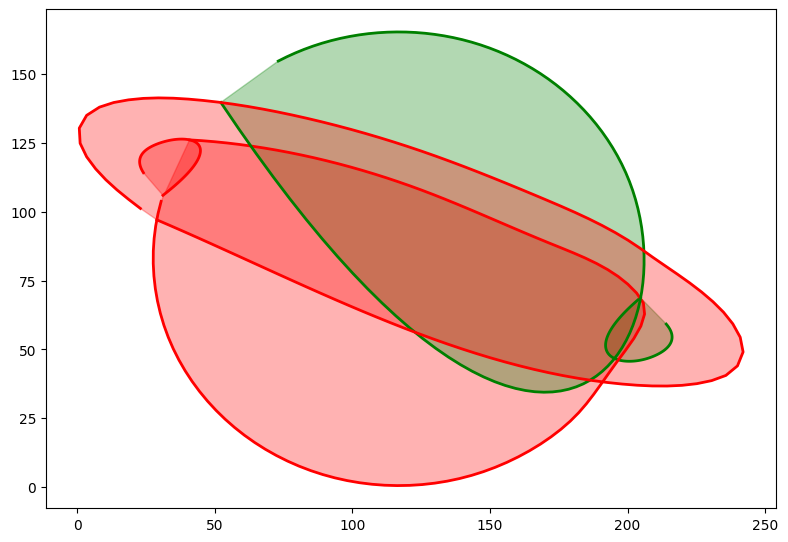

Input image: Disconnected
Output image: Connected
Occlusion has been filled


In [ ]:
input_csv = '/content/occlusion2.csv'
colours = ['red', 'green']

process_csv_and_fill_occlusions(input_csv, colours)

paths_XYs=read_csv(input_csv)
simplified_paths_XYs = rdp_simplify(paths_XYs, epsilon=1.0)
polylines2svg(simplified_paths_XYs, 'simplified_paths.svg', colours)